# Linear stability analysis: growth rate of fastest growing mode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def addTicks(ax,base,linthresh):
    ax.xaxis.set_major_locator(SymmetricalLogLocator(base=base, linthresh=linthresh))
    subs = np.arange(2, 10) * 0.1
    ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=base, subs=subs, linthresh=linthresh))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Filter out ticks inside the linear region
    major_ticks = [t for t in ax.get_xticks() if abs(t) >= linthresh]
    minor_ticks = [t for t in ax.get_xticks(minor=True) if abs(t) >= linthresh]

    major_ticks.extend([-linthresh, linthresh])
    major_ticks = sorted(set(major_ticks))  # remove duplicates and sort

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(which="both", bottom=True)

In [ ]:
def c_im_max(kappa,theta,alpha_x,alpha_y,mu,f0,beta,U,V,rho1,rho2,H1,H2):
    """
    Computes the growth rate of the most unstable mode for the 2-layer QG model
    For background see Sterl et al. (2025) JFM

    kappa, theta: wavenumber magnitude and angle
    alpha_x, alpha_y: x and y components of bottom slope
    mu: inverse frictional timescale
    f0: Coriolis parameter
    beta: meridional gradient of Coriolis parameter
    U, V: background velocity shear
    rho1, rho2: density of the two layers
    H1, H2: depth of the two layers
    """
    # Calculating relevant parameters
    gp = g*(rho2-rho1)/rho2
    F1 = f0**2/(gp*H1)
    F2 = f0**2/(gp*H2)

    # Coordinate transformation: unit vectors in tangential and normal direction of wavenumber vector
    # U_new = (k*U + l*V)/kappa
    # beta_new = k*beta/kappa
    # S = (f0/H2)*(k*alpha_y - l*alpha_x)/kappa
    cos_theta = np.around(np.cos(theta),decimals=15) # to avoid roundoff errors for sin(180), cos(90) and cos(270)
    sin_theta = np.around(np.sin(theta),decimals=15)
    U_new = U*cos_theta + V*sin_theta
    beta_new = beta*cos_theta
    S = f0/H2 * (alpha_y*cos_theta - alpha_x*sin_theta)
    
    # Solving the equation
    a1 = kappa**2 * (kappa**2 + F1 + F2)
    a2 = - U_new*kappa**2 * (kappa**2 + 2*F2) + beta_new * (2*kappa**2 + F1 + F2) + (kappa**2 + F1) * (S + 1j*mu*kappa)
    a3 = (-U_new*kappa**2 + beta_new) * (-F2*U_new + beta_new + S + 1j*mu*kappa)
    D = a2**2 - 4*a1*a3

    sol1 = (-a2 + np.sqrt(D))/(2*a1)
    sol2 = (-a2 - np.sqrt(D))/(2*a1)

    # Computing the imaginary parts of the solutions
    cim1 = np.imag(sol1)
    cim2 = np.imag(sol2)
    cre1 = np.real(sol1)
    cre2 = np.real(sol2)

    # If growth rates are negative, make them NaN (no growth)
    if cim1<=0:
        cim1 = np.nan
    if cim2<=0:
        cim2 = np.nan

    max_growth = np.nanmax((cim1, cim2))
    if np.isnan(max_growth):
        return np.nan, np.nan
    elif max_growth == cim1:
        return kappa*cim1
    else:
        return kappa*cim2

In [6]:
# Define parameters
H1 = 1000
H2 = 4000
rho1 = 1027.6
rho2 = 1028
f0 = 1e-4
g = 9.81
beta = 0
U = 0.2
V = 0
mu = 3e-6
alpha_x = 0

gp = g*(rho2-rho1)/rho2
F1 = f0**2/(gp*H1)
F2 = f0**2/(gp*H2)
F = F1 + F2

k_range = np.arange(0.05,1.351,0.01)*np.sqrt(F)

In [8]:
def mostUnstableGrowthRate(alpha_y):
    growth_rate = np.array([c_im_max(kappa, 0, alpha_x, alpha_y, mu, f0, beta, U, V, rho1, rho2, H1, H2) for kappa in k_range])
    ind = np.unravel_index(np.nanargmax(growth_rate, axis=None), growth_rate.shape)
    max_growth = growth_rate[ind]
    return max_growth

slopes = np.array(['-7e-3','-5e-3','-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
                    '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3'])
alpha_y = [float(s) for s in slopes]
max_growth = np.array([mostUnstableGrowthRate(alpha) for alpha in alpha_y])

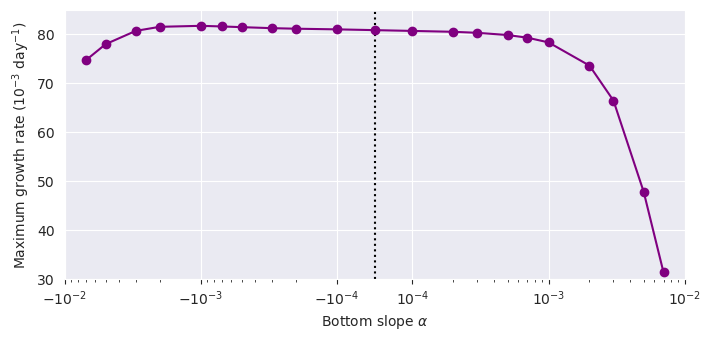

In [22]:
fig, ax = plt.subplots(figsize=(8,3.5))
ax.axvline(0,color='k',linestyle=':')
ax.plot(alpha_y, max_growth*86400*1e3, marker='o', color='purple')
ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
addTicks(ax,10,1e-4)
ax.set_xlim(-1e-2, 1e-2)
ax.set_ylim(30,85)
ax.set_xlabel(r'Bottom slope $\alpha$')
ax.set_ylabel(r'Maximum growth rate ($10^{-3}$ day$^{-1}$)')
plt.savefig('../../Figures/growth_rate.pdf', bbox_inches='tight')
plt.show()